In [223]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline

from importlib.util import find_spec
if find_spec("qml_hep_lhc") is None:
    import sys
    sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [224]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Layer, Flatten, Activation, Dense, Concatenate, Reshape
import tensorflow_quantum as tfq
import tensorflow as tf
import sympy
import cirq
import numpy as np
from qml_hep_lhc.models.quantum.utils import one_qubit_unitary
from tensorflow.math import atan, square

In [225]:
from qml_hep_lhc.data.electron_photon import ElectronPhoton
import argparse

In [226]:
args = argparse.Namespace()

# args.graph_conv = True
# args.quantum = True
# args.pca = 64
args.center_crop = 0.2
# args.normalize = True
# args.threshold = 0
# args.loss = "Hinge"
# args.hinge_labels = True
# args.angle_encoding = True

In [227]:
data = ElectronPhoton(args)
data.prepare_data()
data.setup()

Center cropping...


In [228]:
data.x_train.shape

TensorShape([100, 8, 8, 1])

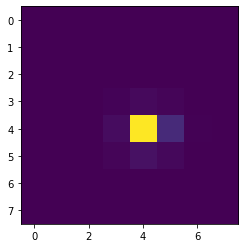

In [229]:
plt.imshow(data.x_train[0])

In [230]:
def entangling_circuit(qubits):
    """
    Returns a layer of CZ entangling gates on `qubits` (arranged in a circular topology).
    """
    cz_ops = [cirq.CZ(q0, q1) for q0, q1 in zip(qubits, qubits[1:])]
    cz_ops += ([cirq.CZ(qubits[0], qubits[-1])] if len(qubits) != 2 else [])
    return cz_ops

In [231]:
def encoding_circuit(qubits,symbols):
    e_ops = [cirq.ry(symbols[index,0]).on(bit) for index, bit in enumerate(qubits)]
    e_ops += [cirq.rz(symbols[index,1]).on(bit) for index, bit in enumerate(qubits)]
    return e_ops

In [295]:
class QuantumConv(Layer):

    def __init__(self,name,
                 kernel_size=3,
                 strides=1,
                 activation='tanh',
                 n_layers =1):
        
        super(QuantumConv, self).__init__(name=name)
        self.kernel_size = kernel_size
        self.strides = strides
        self.activation = Activation(activation)
        self.n_layers = n_layers

        self.n_qubits = kernel_size*kernel_size
        self.qubits = cirq.GridQubit.rect(1, self.n_qubits)
        self.observables = [cirq.Z(self.qubits[0])]

        var_symbols = sympy.symbols(f'qconv0:{3*self.n_qubits*self.n_layers}')
        self.var_symbols = np.asarray(var_symbols).reshape((self.n_layers, self.n_qubits,3))

        in_symbols= sympy.symbols(f'x0:{2*self.n_qubits}')
        self.in_symbols = np.asarray(in_symbols).reshape((self.n_qubits, 2))

    def build(self, input_shape):
        circuit = cirq.Circuit()

        circuit += encoding_circuit(self.qubits, self.in_symbols)
        for layer in range(self.n_layers):
            circuit += entangling_circuit(self.qubits)
            for bit in range(self.n_qubits):
                circuit += one_qubit_unitary(self.qubits[bit], self.var_symbols[layer, bit])
        
        self.var_symbols = list(self.var_symbols.flat)
        self.in_symbols = list(self.in_symbols.flat)

        var_init = tf.random_uniform_initializer(minval=-np.pi/2, maxval=np.pi/2)
        self.theta = tf.Variable(
            initial_value=var_init(shape=(1, len(self.var_symbols)), dtype="float32"),
            trainable=True, name=self.name + "_thetas"
        )

        # Define explicit symbol order
        symbols = [str(symb) for symb in self.var_symbols + self.in_symbols]
        self.indices = tf.constant([symbols.index(a) for a in sorted(symbols)])

        self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])
        self.computation_layer = tfq.layers.ControlledPQC(circuit, self.observables)
         
    def call(self, input_tensor):

        # inputs[0] = encoding data for the state.
        batch_dim = tf.shape(input_tensor)[0]
        strides = self.strides
        kernel_size = self.kernel_size
        
        n = (input_tensor.shape[1] - kernel_size)//strides + 1
        m = (input_tensor.shape[2] - kernel_size)//strides + 1
        
        conv_out = []

        for i in range(n):
            for j in range(m):
                x = input_tensor[:, i*strides:i*strides+kernel_size, j*strides:j*strides+kernel_size]
                x = Flatten()(x)
                
                x1 = self.activation(x)
                x2 = self.activation(square(x))
                tiled_up_circuits = tf.repeat(self.empty_circuit, 
                                              repeats=batch_dim, 
                                              name=self.name + "_tiled_up_circuits")
                tiled_up_thetas = tf.tile(self.theta, 
                                          multiples=[batch_dim, 1], 
                                          name = self.name+"_tiled_up_thetas")
                joined_vars = tf.concat([tiled_up_thetas, x1, x2], axis=-1)
                joined_vars = tf.gather(joined_vars, self.indices, axis=-1, name=self.name +'_joined_vars')
                out = self.computation_layer([tiled_up_circuits, joined_vars])
                conv_out += [out]

        conv_out = Concatenate(axis=1)(conv_out)
        conv_out = Reshape((n, m))(conv_out)
        return conv_out

In [296]:
class QCNNChen(Model):
    """
    Quantum Convolutional Neural Network.
    This implementation is based on https://arxiv.org/abs/2012.12177
    """
    def __init__(self, data_config, args=None):
        super().__init__()
        self.args = vars(args) if args is not None else {}

        # Data config
        self.input_dim = data_config["input_dims"]
        self.conv2d_1 = QuantumConv(kernel_size = 3,
                                    strides = 1,
                                    n_layers =2,
                                    name = 'conv2d_1')
        self.conv2d_2 = QuantumConv(kernel_size = 2,
                                    strides = 1,
                                    n_layers =2,
                                    name = 'conv2d_2')
        self.dense1 = Dense(8,activation='relu')
        self.dense2 = Dense(2,activation='softmax')
        
    def call(self, input_tensor):
        x = self.conv2d_1(input_tensor)
        x = self.conv2d_2(x)
        x = Flatten()(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x
    
    def build_graph(self):
        x = Input(shape=self.input_dim)
        return Model(inputs=[x], outputs=self.call(x), name="QCNNChen")

In [297]:
model = QCNNChen(data.config())

In [298]:
model.build_graph().summary()

Model: "QCNNChen"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 8, 8, 1)]         0         
                                                                 
 conv2d_1 (QuantumConv)      (None, 6, 6)              54        
                                                                 
 conv2d_2 (QuantumConv)      (None, 5, 5)              24        
                                                                 
 flatten_2 (Flatten)         (None, 25)                0         
                                                                 
 dense_78 (Dense)            (None, 8)                 208       
                                                                 
 dense_79 (Dense)            (None, 2)                 18        
                                                                 
Total params: 304
Trainable params: 304
Non-trainable para

In [301]:
from cirq.contrib.svg import SVGCircuit

In [309]:
bit = cirq.GridQubit(0, 0)
model = cirq.Circuit(
    cirq.X(bit) ** sympy.Symbol('alpha'),
    cirq.Z(bit) ** sympy.Symbol('beta')
)
outputs = tfq.layers.ControlledPQC(model, cirq.Z(bit))
quantum_data = tfq.convert_to_tensor([
    cirq.Circuit(),
    cirq.Circuit(cirq.X(bit))
])
model_params = tf.convert_to_tensor([[0.5, 0.5], [0.25, 0.75]])
res = outputs([quantum_data, model_params])
res

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 0.       ],
       [-0.7071067]], dtype=float32)>

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


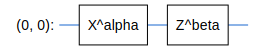

In [304]:
SVGCircuit(model)